In [18]:
pip install RISE

jupyter-nbextentsion install rise --py -
-sys-prefix

SyntaxError: invalid syntax (123437084.py, line 3)

In [2]:
import pandas as pd
import numpy as np 

import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as stats

data = pd.read_excel("https://www.dropbox.com/s/19acuzv2yrwpoun/servicesdataset%202.xlsx?dl=1")
data_original = data.copy()

## Data Cleaning

In [3]:
# Replace missing values with the mean
# data = data.fillna(data.mean())

In [4]:
# Filtering to get countries which trade and have data for GDP, then taking logs
data0 = data[(data['trade'] > 0) & ~(data['gdp_exp'].isnull()) & ~(data['gdp_imp'].isnull()) & ~(data['distw'].isnull())]
data0_b = data0[['exp', 'imp', 'trade', 'distw', 'gdp_exp', 'gdp_imp']]
logdata0 = data0_b.apply(lambda x: np.log(x) if np.issubdtype(x.dtype, np.number)else x)
logdata0_graph = logdata0.copy()
logdata0_graph['combined_gdp'] = logdata0_graph['gdp_exp'] + logdata0_graph['gdp_imp']

In [5]:
logdata0

,exp,imp,trade,distw,gdp_exp,gdp_imp
28,GBR,AGO,5.152221,8.866808,28.161649,23.431316
30,ITA,AGO,2.520591,8.674289,27.726331,23.431316
32,DNK,AGO,3.212943,8.896760,25.859064,23.431316
34,FRA,AGO,4.312351,8.761676,27.967493,23.431316
37,BEL,AGO,2.009766,8.827272,26.244727,23.431316
...,...,...,...,...,...,...
31081,BEL,ZWE,1.316620,9.004719,26.244727,22.446032
31086,NLD,ZWE,2.297448,9.016893,26.739423,22.446032
31087,ITA,ZWE,2.297448,8.864830,27.726331,22.446032
31089,DNK,ZWE,1.603506,9.044623,25.859064,22.446032


## Pre-plots

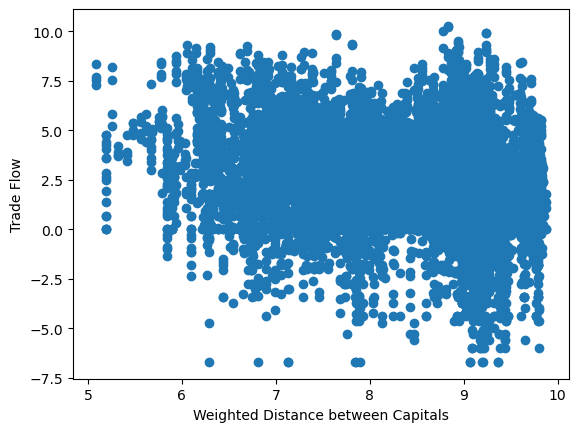

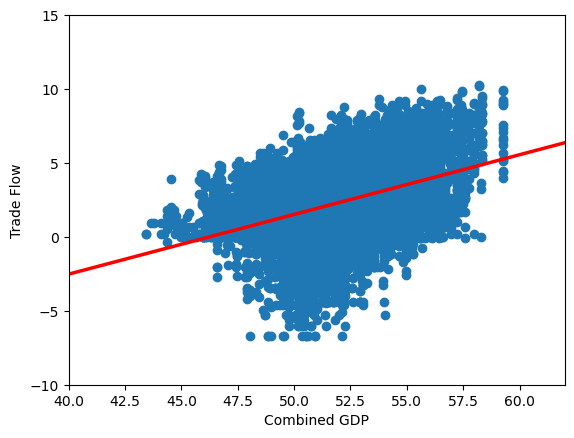

In [6]:
# Visualise 1: Trade flow VS Weighted Distance
plt.scatter(logdata0["distw"], logdata0["trade"])
plt.xlabel("Weighted Distance between Capitals")
plt.ylabel("Trade Flow")
plt.show()

plt.scatter(logdata0_graph["combined_gdp"], logdata0_graph["trade"])
plt.xlabel("Combined GDP")
plt.ylabel("Trade Flow")
plt.xlim([40, 62])
plt.ylim([-10, 15])
b, a = np.polyfit(logdata0_graph["combined_gdp"], logdata0_graph["trade"], deg=1)
xseq = np.linspace(40, 62, num=100)
plt.plot(xseq, a + b * xseq, color="r", lw=2.5)
plt.show()

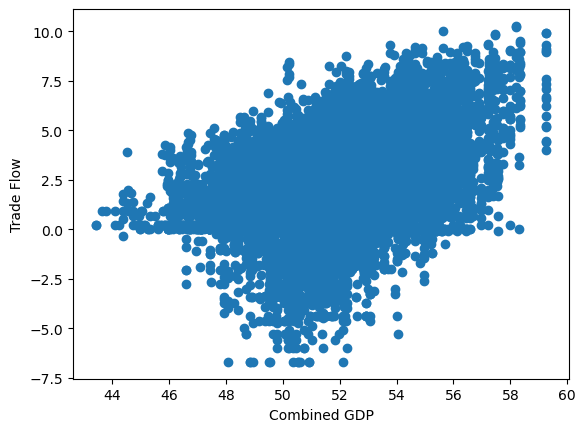

In [7]:
# Visualise 2: Trade flow VS GDP
plt.scatter(logdata0_graph["combined_gdp"], logdata0["trade"])
plt.xlabel("Combined GDP")
plt.ylabel("Trade Flow")
plt.show()

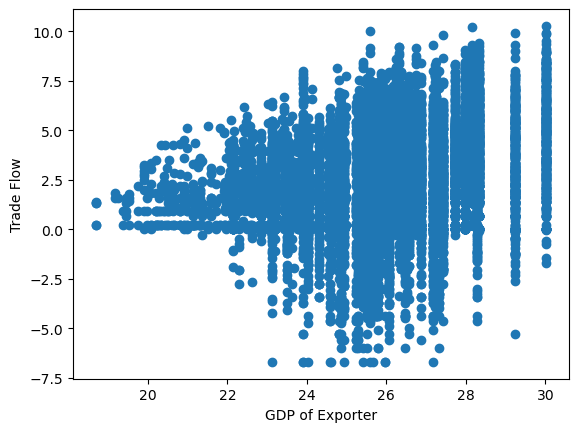

In [8]:
# Visualise 3: Trade flow VS GDP of Exporter
plt.scatter(logdata0["gdp_exp"], logdata0["trade"])
plt.xlabel("GDP of Exporter")
plt.ylabel("Trade Flow")
plt.show()

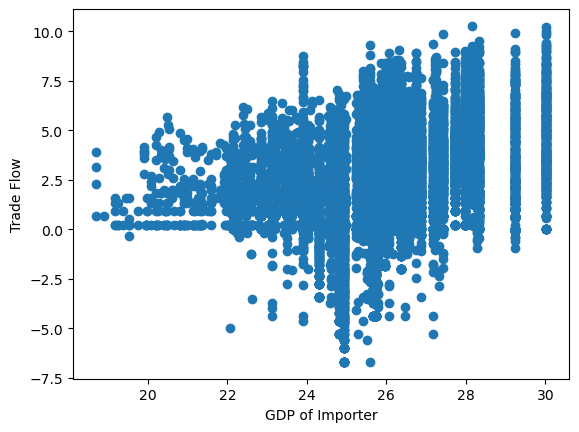

In [9]:
# Visualise 4: Trade flow VS GDP of Importer
plt.scatter(logdata0["gdp_imp"], logdata0["trade"])
plt.xlabel("GDP of Importer")
plt.ylabel("Trade Flow")
plt.show()

## Regression

### 1 | Simple linear regression

$$
\log(trade_{ij}) = \alpha + \beta_1 \log(distw) + \beta_2 \log(GDP_i) +	\beta_3 \log(GDP_j) + ϵ
$$

In [10]:
Y = data["trade"]
X = data[["gdp_exp", "gdp_imp", "distw"]]

# add a constant to the independent variables
X = sm.add_constant(X)

# fit lm model
model1 = sm.OLS(Y, X).fit()

# summary statistics
print(model1.summary())

# coefficients
print(model1.params)

# CHECK THIS
X_a = logdata0.drop(['trade', 'exp', 'imp'], axis=1)
Y_a = logdata0[['trade']]
X_a = sm.add_constant(X_a)
model_no_fix = sm.OLS(Y_a, X_a).fit()
print(model_no_fix.summary())

MissingDataError: exog contains inf or nans

### 2 | Add country fixed effects

$$
\log(trade_{ij}) = Σ_{i=1}^N\alpha_i D_{ni} + \beta_1 \log(distw) + \beta_2 \log(GDP_i) +	\beta_3 \log(GDP_j) + ϵ
$$

where $\alpha$ represents the country, and $D$ a dummy indicating if country $n$ is importing to country $i$

In [ ]:
Y = data["log_trade"]
X = data[["log_gdp_exp", "log_gdp_imp", "log_distw"]]

# add a constant to the independent variables
X = sm.add_constant(X)

# fit lm model
model2 = sm.OLS(Y, X).fit()

# summary statistics
print(model2.summary())

# coefficients
print(model2.params)

# AGAIN CHECK
dummy_data = pd.get_dummies(data = logdata0, prefix = ['exp', 'imp'], columns= ['exp', 'imp'], drop_first = True)

X_b = dummy_data.drop(['trade'], axis=1)
Y_b = dummy_data[['trade']]
X_b = sm.add_constant(X_b)
model_fix_country = sm.OLS(Y_b, X_b).fit()
print(model_fix_country.summary())

### 3 | Add sector fixed effects

$$
\log(trade_{ij}) = Σ_{i=1}^N\alpha_i D_{ni} + \beta_1 \log(distw) + \beta_2 \log(GDP_i) +	\beta_3 \log(GDP_j) + ϵ
$$

where $\alpha$ represents the country, and $D$ a dummy indicating if country $n$ is mainly of sector type $i$

In [ ]:
data0_sector = data0[['exp', 'imp', 'sector', 'trade', 'distw', 'gdp_exp', 'gdp_imp']]
logdata0_sector = data0_sector.apply(lambda x: np.log(x) if np.issubdtype(x.dtype, np.number)else x)
dummy_data_sector = pd.get_dummies(data = logdata0_sector, prefix = ['exp', 'imp', 'sector'], columns= ['exp', 'imp','sector'], drop_first = True)
dummy_data_sector

In [ ]:
X_sector = dummy_data_sector.drop(['trade'], axis=1)
Y_sector = dummy_data_sector[['trade']]
X_sector = sm.add_constant(X_sector)
model_fix_sector = sm.OLS(Y_sector, X_sector).fit()
print(model_fix_sector.summary())

### 4 | Using a ln(x+1) transformation to include the trade data with value of zero

In [ ]:
# Filtering for GDP and distance data which is available, and taking logs
data = data[~(data['gdp_exp'].isnull()) & ~(data['gdp_imp'].isnull()) & ~(data['distw'].isnull())]
data = data[['exp', 'imp', 'trade', 'distw', 'gdp_exp', 'gdp_imp']]
logdata = data.apply(lambda x: np.log(x+1) if np.issubdtype(x.dtype, np.number)else x)
logdata_graph = logdata.copy()
logdata_graph['combined_gdp'] = logdata_graph['gdp_exp'] + logdata_graph['gdp_imp']

In [ ]:
# Adding dummy variables for countries to take fixed effects
dummy_data = pd.get_dummies(data = logdata, prefix = ['exp', 'imp'], columns= ['exp', 'imp'], drop_first = True)
X = dummy_data.drop(['trade'], axis=1)
Y = dummy_data[['trade']]
X = sm.add_constant(X)
OLS = sm.OLS(Y, X).fit()
OLS.summary()

In [ ]:
# Visualisation: Trade flow VS GDP (do we want to keep line? & change colours)
plt.scatter(logdata_graph["combined_gdp"], logdata_graph["trade"])
plt.xlabel("Combined GDP")
plt.ylabel("Trade Flow")
plt.show()

## Evaluate results

### Basic metrics (include?)

In [ ]:
# Check the significance and sign of the coefficients
print(model1.pvalues)
print(np.sign(model1.params))

# Calculate and print the R-squared value
print("R-squared:", model1.rsquared)

In [ ]:
# Check the significance and sign of the coefficients
print(model2.pvalues)
print(np.sign(model2.params))

# Calculate and print the R-squared value
print("R-squared:", model2.rsquared)

In [ ]:
# Check the significance and sign of the coefficients
print(model3.pvalues)
print(np.sign(model2.params))

# Calculate and print the R-squared value
print("R-squared:", model3.rsquared)

### Check if GM assumptions hold
Check if GM assumptions hold

1. Linearity: the parameters we are estimating using the OLS method must be themselves linear.
2. Random: our data must have been randomly sampled from the population.
3. Non-Collinearity: the regressors being calculated aren’t perfectly correlated with each other.
4. Exogeneity: the regressors aren’t correlated with the error term.
5. Homoscedasticity: no matter what the values of our regressors might be, the error of the variance is constant.

In [ ]:
# Testing area
model_fix_sector.rsquared_adj

In [ ]:
def r_sq(model):
    return f"Adjusted R-squared: {model.rsquared_adj}"

def test_assumptions(model, X):
    residuals = model.resid

    # NORMALITY OF THE RESIDUALS -----------------------------------------------
    # Shapiro-Wilk test
    stat, p = stats.shapiro(residuals)
    print("Shapiro-Wilk test statistic:", stat)
    print("p-value:", p)
    # Q-Q plot
    sm.qqplot(residuals, line="s")
    plt.title("Normality?")
    plt.show()
    print()

    # HOMOSKEDASTICITY OF THE RESIDUALS ----------------------------------------
    # Breusch-Pagan test
    bp_test = sm.stats.diagnostic.het_breuschpagan(residuals, X)
    print("Breusch-Pagan test statistic:", bp_test[0])
    print("p-value:", bp_test[1])
    # scatter plot of the residuals vs. the predicted values
    plt.scatter(model.predict(X), residuals)
    plt.axhline(y=0, color="r", linestyle="-")
    plt.xlabel("Predicted values")
    plt.ylabel("Residuals")
    plt.title("Homoskedasticity? Residuals vs. Predicted values")
    plt.show()
    print()

    # LINEARITY of the relationship --------------------------------------------
    # Scatter plot of the residuals vs. the predicted values
    plt.scatter(model.predict(X), residuals)
    plt.axhline(y=0, color="r", linestyle="-")
    plt.xlabel("Predicted values")
    plt.ylabel("Residuals")
    plt.title("Linearity? Residuals vs. the Predicted values")
    plt.show()
    print()


models = [model_no_fix, model_fix_country, model_fix_sector]
model_names = ['model_no_fix', 'model_fix_country', 'model_fix_sector']
X = [X_a, X_b, X_sector]

for i, model in enumerate(models):
    print(f'Model: {model_names[i]} -------------------------------------- \n')
    print(r_sq(model))
    print()
    test_assumptions(model, X[i])
    print('---------------------------------------------------------------')

In [ ]:
# Calculate the residuals
residuals = model1.resid

# Test for NORMALITY using the Shapiro-Wilk test
stat, p = stats.shapiro(residuals)
print("Shapiro-Wilk test statistic:", stat)
print("p-value:", p)

# Check the NORMALITY of the residuals using a Q-Q plot
sm.qqplot(residuals, line="s")
plt.show()

# Test for HOMOSKEDASTICITY using the Breusch-Pagan test
bp_test = sm.stats.diagnostic.het_breuschpagan(residuals, X)
print("Breusch-Pagan test statistic:", bp_test[0])
print("p-value:", bp_test[1])

# Check HOMOSKEDASTICITY using a scatter plot of the residuals vs. the predicted values
plt.scatter(model1.predict(X), residuals)
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.show()

# Check the LINEARITY of the relationship using a scatter plot of the residuals vs. the predicted values
plt.scatter(model1.predict(X), residuals)
plt.axhline(y=0, color="r", linestyle="-")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.show()

In [ ]:
# Calculate the residuals
residuals = model2.resid

# Test for NORMALITY using the Shapiro-Wilk test
stat, p = stats.shapiro(residuals)
print("Shapiro-Wilk test statistic:", stat)
print("p-value:", p)

# Check the NORMALITY of the residuals using a Q-Q plot
sm.qqplot(residuals, line="s")
plt.show()

# Test for HOMOSKEDASTICITY using the Breusch-Pagan test
bp_test = sm.stats.diagnostic.het_breuschpagan(residuals, X)
print("Breusch-Pagan test statistic:", bp_test[0])
print("p-value:", bp_test[1])

# Check HOMOSKEDASTICITY using a scatter plot of the residuals vs. the predicted values
plt.scatter(model2.predict(X), residuals)
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.show()

# Check the LINEARITY of the relationship using a scatter plot of the residuals vs. the predicted values
plt.scatter(model2.predict(X), residuals)
plt.axhline(y=0, color="r", linestyle="-")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.show()

## Visualising results 

In [ ]:
import seaborn as sns

### Heatmap

In [ ]:
#Create pivot table
table = data.pivot(index='country_i', columns='country_j', values='trade')

#Create heatmap
sns.heatmap(table, cmap='YlGnBu', square=True)

### Network graph / map

In [ ]:
import networkx as nx

In [ ]:
# Create graph
G = nx.from_pandas_edgelist(data, source='country_i', target='country_j', edge_attr='trade')

# Set node attributes
for node in G.nodes:
    G.nodes[node]['GDP_exp'] = data.loc[data['country_i'] == node, 'GDP_exp'].iloc[0]

# Create layout
pos = nx.spring_layout(G)

# Draw graph
nx.draw_networkx_nodes(G, pos, node_size=GDP, node_color='red')
nx.draw_networkx_edges(G, pos, edge_color='gray')
nx.draw_networkx_labels(G, pos)
plt.axis('off')
plt.show()

In [ ]:
!pip install geopandas
import geopandas as gpd

In [ ]:
# Read the Shapefile using geopandas
gdf = gpd.read_file("/vsicurl/https://github.com/nvkelso/natural-earth-vector/raw/master/50m_cultural/ne_50m_admin_0_countries.shp")

In [ ]:
# Unique country list
country_list = data['exp'].unique().tolist()
print(country_list)

## Export map

In [ ]:
# Getting total exports for each country
exp_dict = {}

for c in country_list:
    exp_dict[c] = data.loc[data['exp'] == c, 'trade'].sum()

agg_export = pd.DataFrame(list(exp_dict.items()), columns=['Country', 'Export'])
agg_export.head()

In [ ]:
agg_export.sort_values(by=['Export'], ascending = False)

In [ ]:
# Merging export data with gdf
merged_exp = gdf.set_index("ADM0_A3").join(agg_export.set_index("Country"))
merged_exp.head()

In [ ]:
# Plot the export map
fig, ax = plt.subplots(figsize=(50, 40))
merged_exp.plot(column = 'Export', cmap = 'Greens', linewidth = 0.8, ax=ax)

# Adding country names
for i,geo in merged_exp.centroid.items():
    ax.annotate(text=i,xy=[geo.x,geo.y],horizontalalignment="center",color="black")
    ax.axis('off')
    ax.set_title('World Exports by country',fontdict={'fontsize':'25','fontweight':'3'})
plt.show()

## Import map

In [ ]:
# Getting total imports for each country
imp_dict = {}

for c in country_list:
    imp_dict[c] = data.loc[data['imp'] == c, 'trade'].sum()

agg_import = pd.DataFrame(list(imp_dict.items()), columns=['Country', 'Import'])
agg_import.head()

In [ ]:
# Merging import data with gdf
merged_imp = gdf.set_index("ADM0_A3").join(agg_import.set_index("Country"))
merged_imp.head()

In [ ]:
# Plot the import map
fig, ax = plt.subplots(figsize=(50, 40))
merged_imp.plot(column = 'Import',cmap = 'Blues', linewidth = 0.8, ax=ax)

# Adding country names
for i,geo in merged_imp.centroid.items():
    ax.annotate(text=i,xy=[geo.x,geo.y],horizontalalignment="center",color="black")
    ax.axis('off')
    ax.set_title('World Imports by country',fontdict={'fontsize':'25','fontweight':'3'})
plt.show()

## Combined trade map

In [ ]:
# Getting combined trade for each country
agg_trade = agg_export.set_index('Country').join(agg_import.set_index('Country'))
agg_trade['Combined'] = agg_trade['Export'] + agg_trade['Import']
agg_trade = agg_trade.drop('Export', axis=1)
agg_trade = agg_trade.drop('Import', axis=1)
agg_trade.head()

In [ ]:
# Merging combined trade data with gdf
merged_comb = gdf.set_index("ADM0_A3").join(agg_trade)
merged_comb.head()

In [ ]:
# Plot the combined trade map
fig, ax = plt.subplots(figsize=(50, 40))
merged_comb.plot(column = 'Combined', cmap = 'Reds', linewidth = 0.8, ax=ax)

# Adding country names
for i,geo in merged_comb.centroid.items():
    ax.annotate(text=i,xy=[geo.x,geo.y],horizontalalignment="center",color="black")
    ax.axis('off')
    ax.set_title('World Trade by country',fontdict={'fontsize':'25','fontweight':'3'})
plt.show()

## EU map

In [ ]:
# Creating EU dataframes
EU = ['AUT','BEL','CYP','CZE','DNK','EST','FIN','FRA','DEU','GRC','HUN','IRL','ITA','LVA','LTU','LUX','MLT','NLD','POL','PLT','SVK','SVN','ESP','SWE','GBR']

europe_exp_merged = merged_exp.query("ADM0_A3 in @EU")
europe_imp_merged = merged_imp.query("ADM0_A3 in @EU")
europe_tot_merged = merged_tot.query("ADM0_A3 in @EU")

In [ ]:
# Plot the European export map
fig, ax = plt.subplots(figsize=(30, 20))
europe_exp_merged.plot(column = 'Export',cmap = 'Greens', linewidth = 0.8, ax=ax)

# Adding country names
for i,geo in europe_exp_merged.centroid.items():
    ax.annotate(text=i,xy=[geo.x,geo.y],horizontalalignment="center",color="black")
    ax.axis('off')
    ax.set_title('EU export by country',fontdict={'fontsize':'25','fontweight':'3'})
plt.show()